# Customer Behaviour Analysis from Bay Wheels Trips data

## Investigation Overview

In this investigation, we look at the bike trips of Bay Wheels made in March 2020. We find out how the customers use the bike sharing service and find out how varied is the behaviour of different types of customers. We see if there is any variance in their behaviour in terms of trip duration and the time of day of taking the trips. We also look at the popularity of the bike stations to find out which bike stations need more focus.

## Dataset Overview

The data contains information about 176799 rides done in March 2020. It has information including the duration of the trip, the start and end time of the trip, the stations from where the trip was started and ended, whether the customer is a subscriber to Bay Wheels or a casual customer, and if the customer used the app to access the bike or a Clipper Card.

In [2]:
# Importing packages needed and setting visibility for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import zipfile

% matplotlib inline

# To supress warnings in the final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# Getting the file from the website
dataset_url = "https://s3.amazonaws.com/baywheels-data/202003-baywheels-tripdata.csv.zip"
req = requests.get(dataset_url)
file_name = dataset_url.split('/')[-1]

In [ ]:
# Downloading file in ZIP format
open(file_name, 'wb').write(req.content)

In [6]:
# Extracting ZIP file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
data_file = file_name.replace('.zip', '')

In [5]:
# Reading file into pandas and having a look at it
trip_data_df = pd.read_csv(data_file)

In [6]:
# Converting to datetime object
trip_data_df['start_time'] = pd.to_datetime(trip_data_df['start_time'])
trip_data_df['end_time'] = pd.to_datetime(trip_data_df['end_time'])

In [7]:
# Converting to string
trip_data_df['bike_id'] = trip_data_df['bike_id'].astype(str)

In [8]:
# Converting to category
trip_data_df['user_type'] = trip_data_df['user_type'].astype('category')
trip_data_df['user_type'].cat.reorder_categories(['Customer', 'Subscriber'], inplace=True)

In [9]:
trip_data_df['rental_access_method'] = trip_data_df['rental_access_method'].astype('category')

In [10]:
def get_time_of_day(x):
    '''Takes in a pandas datetime object and returns the time of the day'''
    if x.hour >= 6 and x.hour < 12:
        return 'morning'
    elif x.hour >= 12 and x.hour < 17:
        return 'afternoon'
    elif x.hour >= 17 and x.hour < 20:
        return 'evening'
    else:
        return 'night'

In [11]:
# Creating a categorical column for start and end time of day
trip_data_df['start_time_of_day'] = trip_data_df['start_time'].apply(get_time_of_day).astype('category').cat.reorder_categories(['morning', 'afternoon', 'evening', 'night'])
trip_data_df['end_time_of_day'] = trip_data_df['end_time'].apply(get_time_of_day).astype('category').cat.reorder_categories(['morning', 'afternoon', 'evening', 'night'])

## How customers use Bay Wheels

In the graph below, 'Customer' denotes a casual customer, while 'Subscriber' denotes a customer who has subscribed to Bay Wheels. More customers find value in the subscription service, but there are still a large chunk of customers who rent bikes without subscribing.

The vast majority of customers prefer to rent by using the app rather than the Clipper Card. There is a need to promote the card more, and get feedback from customers to see what would make them use it.

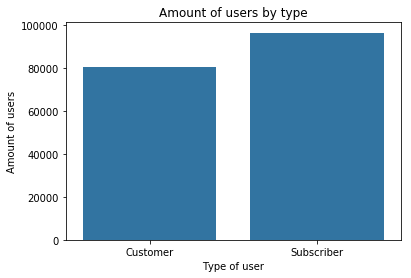

In [12]:
# Plotting count plot based on user type
color = sb.color_palette()[0]
sb.countplot(trip_data_df['user_type'], color=color)
plt.xlabel('Type of user')
plt.ylabel('Amount of users')
plt.title('Amount of users by type');

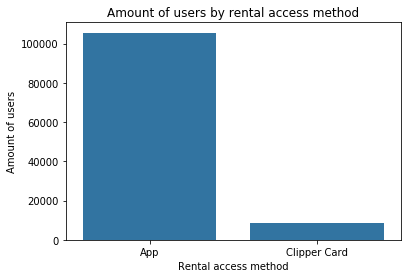

In [13]:
# Plotting count plot based on rental access method of customer
color = sb.color_palette()[0]
sb.countplot(trip_data_df['rental_access_method'], color=color)
plt.xlabel('Rental access method')
plt.ylabel('Amount of users')
plt.xticks([0, 1], ['App', 'Clipper Card'])
plt.title('Amount of users by rental access method');

## How long do customers ride?

Most customers ride bikes for a short period of time, somewhere between 4-8 minutes. Customers do not prefer to ride for longer periods of time.

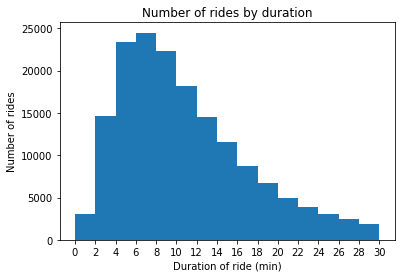

In [14]:
# Plotting histogram without outliers based on above description
bins = np.arange(0, 1800 + 120, 120)
xtick_labels = ["{}".format(int(x / 60)) for x in bins] # Creating labels in minutes
plt.hist(trip_data_df['duration_sec'], bins=bins)
plt.xlabel('Duration of ride (min)')
plt.ylabel('Number of rides')
plt.xticks(bins, xtick_labels)
plt.title('Number of rides by duration');

## What bike stations are the most used?

The San Francisco Caltrain station at Townsend St. at 4th St. is the most popular station for both starting and ending rides. Other start and end stations are also shown in the graphs.

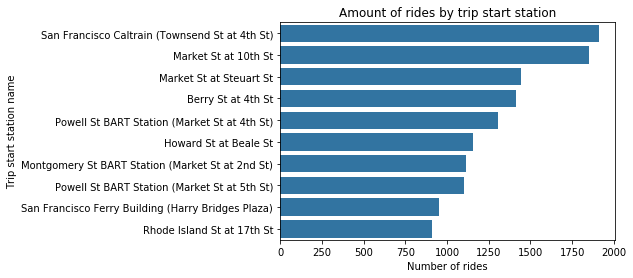

In [20]:
# Calculating popular stations by start time
popular_bikes = trip_data_df['start_station_name'].value_counts()[:10].reset_index()
popular_bikes.columns = ['start_station_name', 'count']
popular_bikes = popular_bikes.sort_values('count', ascending=False)

# Plotting bar chart for the above
color = sb.color_palette()[0]
sb.barplot(data = popular_bikes, y = 'start_station_name', x = 'count', color = color, order = popular_bikes['start_station_name'])
plt.xlabel('Number of rides')
plt.ylabel('Trip start station name')
plt.title('Amount of rides by trip start station');

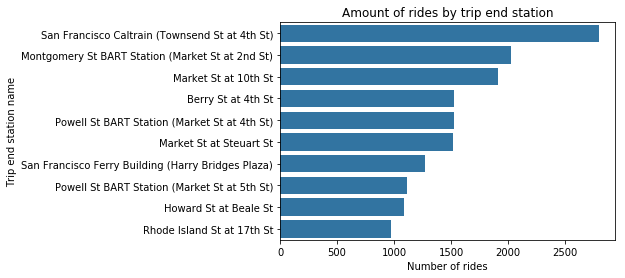

In [21]:
# Calculating popular stations by end time
popular_bikes = trip_data_df['end_station_name'].value_counts()[:10].reset_index()
popular_bikes.columns = ['end_station_name', 'count']
popular_bikes = popular_bikes.sort_values('count', ascending=False)

# Plotting bar chart for the above
color = sb.color_palette()[0]
sb.barplot(data = popular_bikes, y = 'end_station_name', x = 'count', color = color, order = popular_bikes['end_station_name'])
plt.xlabel('Number of rides')
plt.ylabel('Trip end station name')
plt.title('Amount of rides by trip end station');

## How many and what kind of customers ride at different times of day?

We find out how may subscribers and casual customers start and end their trips during what times of the day. We discover that both start and end times follow a similar distribution, and both casual customers and subscribers proportionally ride more in the afternoon followed by the morning. A large number of customers do take trips in the evening, but this period is not as popular as the above two. Naturally, nights are the least popular period to ride bikes.

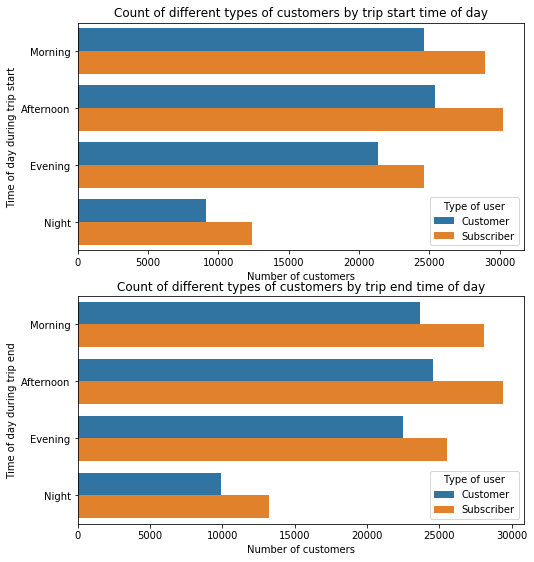

In [28]:
# Plotting clustered bar charts for the above four variables
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2, 1, 1)
sb.countplot(data=trip_data_df, y='start_time_of_day', hue='user_type')
plt.subplots_adjust(bottom=0.01)
ax.set_title('Count of different types of customers by trip start time of day')
ax.set_xlabel('Number of customers')
ax.set_ylabel('Time of day during trip start')
plt.yticks([0, 1, 2, 3], ['Morning', 'Afternoon', 'Evening', 'Night'])
plt.legend(title='Type of user')

ax = fig.add_subplot(2, 1, 2)
sb.countplot(data=trip_data_df, y='end_time_of_day', hue='user_type')
ax.set_title('Count of different types of customers by trip end time of day')
ax.set_xlabel('Number of customers')
ax.set_ylabel('Time of day during trip end')
plt.yticks([0, 1, 2, 3], ['Morning', 'Afternoon', 'Evening', 'Night'])
plt.legend(title='Type of user');